# Tests
I want to test the classification via the reversed condition $\frac{\sigma_n}{\sigma_1}$ on some examples. We only consider the first derivative here
1. $exp(at + x)$ solves $u_t=au=au_x$
2. $cos(at - x)$ solves $u_t=-au_x$
3. $-sin(at - x)$ solves $u_t=-au_x$
4. $(at + x)exp(b t)$ solves $u_t=au_x + bu$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank, svd
import pandas as pd
import pysindy as ps
import os
import sys
sys.path.append('../')
from test_data import *
from error_bounds import *

In [2]:
def classify_string(linear_string):
    if 'nonunique' in linear_string:
        return 'nonunique'
    elif 'unique' in linear_string:
        return 'unique'
    else:
        return None

In [3]:
experiment_names= ['linear_nonunique_1','linear_nonunique_1.1','linear_nonunique_1.2','linear_unique_1']
experiment_name = "linear_nonunique_1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_nonunique_1
exp(0.94176004529503*t + x)


In [4]:
# Choose C,C1,C2
C=1 #<=sv_max
C1=2000 #>=sv_max
C2=1e-02#<=sv_min -> Essentially this boils down to the original problem  of knowing when sv_min is too small to classify the PDE as unique
print(f"For Non-Uniquness: \t \t C = {C:.3e} <= sv_max")
print(f"For Uniqueness: \t C1 = {C1:.3e} >= sv_max")
print(f"\t \t \t C2 = {C2:.3e} <= sv_min")

For Non-Uniquness: 	 	 C = 1.000e+00 <= sv_max
For Uniqueness: 	 C1 = 2.000e+03 >= sv_max
	 	 	 C2 = 1.000e-02 <= sv_min


In [118]:
result= pd.DataFrame(columns=["noise_level","order","ratio","threshold1_uniq","threshold2_uniq","threshold1_nonuniq","threshold2_nonuniq","sv_max","sv_min","C","C1","C2"])
M=infinity_norm(u)
number_noise=9 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
unorm2=np.sqrt(np.mean(np.square(u)))

for noise_level in noise_levels:    
    
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    # Need intitial value for C,C1 and C2
    ux_noise = ps.FiniteDifference(order=2,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    sv = svd(g_noise, compute_uv=False)
    C=sv[0]*0.9 #<=sv_max
    C1=sv[0]*1.2 #>=sv_max
    C2=1e-02#<=sv_min

    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[-1]/sv[0]

        #Potential upper bounds for |G-G_noise| 
        E1=np.sqrt(eps_infty/dx+dx**order)
        E2 = np.sqrt(error_bound_g(eps_two,eps_infty,dx,u.shape[0],M,order))
        
        threshold1_uniq =  calc_threshold_uniq(C1,C2,E1)
        threshold2_uniq =  calc_threshold_uniq(C1,C2,E2)
  
        threshold1_nonuniq = calc_threshold_nonuniq(E1,C)
        threshold2_nonuniq = calc_threshold_nonuniq(E2,C)

        result.loc[len(result.index)] = [noise_level,order,ratio,threshold1_uniq,threshold2_uniq,threshold1_nonuniq,threshold2_nonuniq,sv[0],sv[-1],C,C1,C2]

In [105]:
#Save results
# Creating the directory if it doesn't exist
directory_path="results/" + experiment_name
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    
#Calculates the ratio how many ratios omin/omax were below or above the threshold and classifies with this info
tmp = pd.DataFrame({"threshold1_uniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] > group['threshold1_uniq']).mean()*100),
             "threshold2_uniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] > group['threshold2_uniq']).mean()*100),
             "threshold1_nonuniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] < group['threshold1_nonuniq']).mean()*100),
             "threshold2_nonuniq":result.groupby('noise_level').apply(lambda group: (group['ratio'] < group['threshold2_nonuniq']).mean()*100)})
tmp["Classification1"]=tmp.apply(lambda row: "unique" if row['threshold1_nonuniq'] < row['threshold1_uniq'] else( "nonunique" if row['threshold1_nonuniq'] > row['threshold1_uniq'] else None), axis=1)
tmp["Classification2"]=tmp.apply(lambda row: "unique" if row['threshold2_nonuniq'] < row['threshold2_uniq'] else( "nonunique" if row['threshold2_nonuniq'] > row['threshold2_uniq'] else None), axis=1)
tmp["ClassificationTrue"]=classify_string(experiment_name)
result.to_csv(directory_path+"/results.csv")
print(tmp)

              threshold1_uniq  threshold2_uniq  threshold1_nonuniq  \
noise_level                                                          
0.000000e+00        44.444444        44.444444           66.666667   
1.000000e-10        44.444444        44.444444           66.666667   

              threshold2_nonuniq Classification1 Classification2  \
noise_level                                                        
0.000000e+00           66.666667       nonunique       nonunique   
1.000000e-10           66.666667       nonunique       nonunique   

             ClassificationTrue  
noise_level                      
0.000000e+00          nonunique  
1.000000e-10          nonunique  


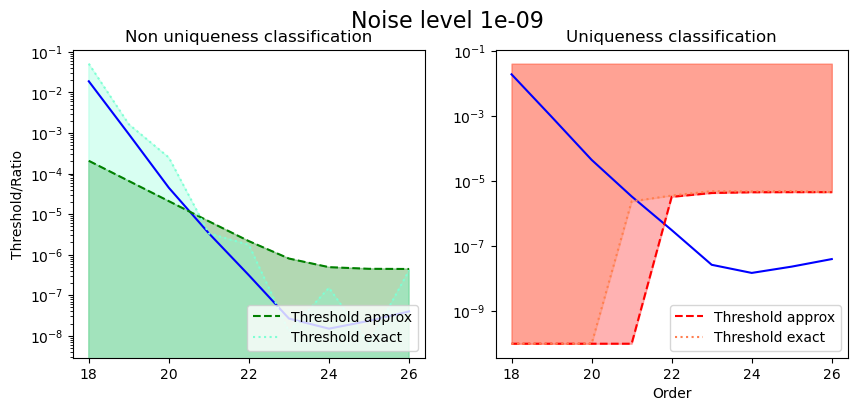

In [122]:
# Create subplots
noise_level=1e-9
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
fig.suptitle(f'Noise level {noise_level}', fontsize=16)
df = result[result["noise_level"] == noise_level]

# Subplot 1: ratio and green lines
ax1.set_title("Non uniqueness classification")
ax1.plot(df["ratio"],color='blue')
ax1.plot( df["threshold1_nonuniq"], '--', label='Threshold approx', color='green')
ax1.plot(df["threshold2_nonuniq"], ':', label='Threshold exact', color='aquamarine')
ax1.fill_between(df.index, 0, df["threshold1_nonuniq"], color='green', alpha=0.3)
ax1.fill_between(df.index, 0, df["threshold2_nonuniq"], color='aquamarine', alpha=0.3)
ax1.set_yscale('log')
ax1.set_ylabel('Threshold/Ratio')

# Subplot 2: ratio and red lines
ax2.set_title("Uniqueness classification")
ax2.plot(df["ratio"],color='blue')
ax2.plot( df["threshold1_uniq"], '--', label='Threshold approx', color='red')
ax2.plot( df["threshold2_uniq"], ':', label='Threshold exact', color='coral')
ax2.fill_between(df.index, df["threshold1_uniq"], y2=result.ratio.max(), color='red', alpha=0.3)
ax2.fill_between( df.index, df["threshold2_uniq"], y2=result.ratio.max(), color='coral', alpha=0.3)
ax2.set_yscale('log')


ax2.set_xlabel('Order')
ax1.legend(loc=4)
ax2.legend(loc=4)

In [ ]:
# Create a figure with multiple subplots
noise_levels = [0]+[10**(-10+i) for i in range(0,8)]
num_cols = 4
num_rows = int(np.ceil(len(noise_levels)*2/num_cols))
fig, axs = plt.subplots(num_rows, num_cols,  figsize=(5*num_cols, 4 *num_rows))
fig.suptitle('Classification for different Noise Levels', fontsize=16)

# Iterate over noise levels
j=0
for i, noise_level in enumerate(noise_levels,start=0):
    df = result[result["noise_level"] == noise_level]
    print(i)
    print(i//(num_rows -1),j%num_cols)
    print(i//(num_rows -1),(j+1)%num_cols)
    # Subplot 1: ratio and green lines
    axs[i//(num_rows -1), j%num_cols].set_title(f"Non uniqueness Noise Level {noise_level}")
    axs[i//(num_rows -1), j%num_cols].plot(df["ratio"], color='blue')
    axs[i//(num_rows -1), j%num_cols].plot(df["threshold1_nonuniq"], '--', label='Threshold approx', color='green')
    axs[i//(num_rows -1), j%num_cols].plot(df["threshold2_nonuniq"], ':', label='Threshold exact', color='aquamarine')
    axs[i//(num_rows -1), j%num_cols].fill_between(df.index, 0, df["threshold1_nonuniq"], color='green', alpha=0.3)
    axs[i//(num_rows -1), j%num_cols].fill_between(df.index, 0, df["threshold2_nonuniq"], color='aquamarine', alpha=0.3)
    axs[i//(num_rows -1), j%num_cols].set_yscale('log')
    axs[i//(num_rows -1), j%num_cols].set_ylabel('Threshold/Ratio')

    # Subplot 2: ratio and red lines
    axs[i//(num_rows -1), (j+1)%num_cols].set_title(f"Uniqueness Noise Level {noise_level}")
    axs[i//(num_rows -1), (j+1)%num_cols].plot(df["ratio"], color='blue')
    axs[i//(num_rows -1), (j+1)%num_cols].plot(df["threshold1_uniq"], '--', label='Threshold approx', color='red')
    axs[i//(num_rows -1), (j+1)%num_cols].plot(df["threshold2_uniq"], ':', label='Threshold exact', color='coral')
    axs[i//(num_rows -1), (j+1)%num_cols].fill_between(df.index, df["threshold1_uniq"], y2=result["ratio"].max(), color='red', alpha=0.3)
    axs[i//(num_rows -1), (j+1)%num_cols].fill_between(df.index, df["threshold2_uniq"], y2=result["ratio"].max(), color='coral', alpha=0.3)
    axs[i//(num_rows -1), (j+1)%num_cols].set_yscale('log')

    axs[i//(num_rows -1), (j+1)%num_cols].set_xlabel('Order')
    axs[i//(num_rows -1), j%num_cols].legend(loc=4)
    axs[i//(num_rows -1), (j+1)%num_cols].legend(loc=4)
    j+=2

# Show the plot
plt.show()


0
0 0
0 1
1
0 2
0 3
2
0 0
0 1
3
0 2
0 3
4
1 0
1 1
5
1 2
1 3
6
1 0
1 1
7
1 2
1 3
8
2 0
2 1
